# Вводная информация об объекте исследования
Вы будете работать с данными, которые собираются с самосвалов, перевозящих породу (например, уголь) на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Сам по себе карьер состоит из пунктов погрузки (откуда вывозят породу), пунктов разгрузки (куда её отвозят) и маршрутов между ними. На картинке показан пример исходных данных координат самосвалов (синие точки) и примерных дорог на карьере (фиолетовые). Пункты погрузки и разгрузки на картинке не указаны.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

![](https://drive.google.com/uc?export=view&id=1QLscdUpjOGU8m9WvN8ulKdC9YBWJyKw4)

# Часть 1. SQL

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, относительно всех записей по данному датчику за последние сутки.

In [ ]:
WITH valid_height_records AS (
    SELECT t.objectid, 
           COUNT(*) AS total_records,
           SUM(CASE 
                   WHEN s.tag = 'height' 
                   AND t.value BETWEEN s.min_value AND s.max_value 
                   THEN 1 
                   ELSE 0 
               END) AS height_records
    FROM telemetry t
    INNER JOIN sensors s ON t.sensorid = s.id
    INNER JOIN objects o ON t.objectid = o.id
    WHERE o.modelname = 'БелАЗ-75320'
    AND o.enterprise_id = 6
    AND t.time >= DATE_SUB(NOW(), INTERVAL 1 DAY)
    GROUP BY t.objectid
)

SELECT vhr.objectid, 
       (vhr.height_records / vhr.total_records) * 100 AS height_percentage
FROM valid_height_records vhr;


## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT DISTINCT t.objectid, t.value AS satenum
FROM telemetry t
INNER JOIN objects o ON t.objectid = o.id
WHERE t.sensorid = (SELECT id FROM sensors WHERE name = 'satenum')
AND t.objectid IN (34, 42, 99)
AND t.time >= DATE_SUB(NOW(), INTERVAL 2 DAY);

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
SELECT 
    objectid,
    CASE 
        WHEN ABS((t1.value - t2.value) / t2.value * 100) > 5 
        THEN 1 
        ELSE 0 
    END AS anomaly_detected
FROM 
    telemetry t1
    JOIN telemetry t2 ON t1.objectid = t2.objectid AND t1.time > t2.time
    JOIN objects o ON t1.objectid = o.id
WHERE 
    t1.sensorid = (SELECT id FROM sensors WHERE name = 'fuel_tank_level')
    AND t2.sensorid = (SELECT id FROM sensors WHERE name = 'fuel_tank_level')
    AND o.modelname = 'БелАЗ-75131'
    AND t1.time >= DATE_SUB(NOW(), INTERVAL 1 HOUR)
ORDER BY 
    objectid, 
    t1.time DESC;

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [406]:
telemetry_df = pd.read_parquet('telemetry.parquet')
telemetry_df.head(10)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.700000,390.000000,NaN,99.990000,0,0,60.000000,216.000000,1003671.000000,215.000000,2891.000000,1,636592.202274,7025133.208573
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.000000,280.000000,0.000000,0.000000,8.000000,0,0,NaN,NaN,1003657.000000,216.000000,2887.000000,0,637716.857273,7025865.991589
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.200000,228.000000,66.850000,778.000000,5.000000,0,0,NaN,NaN,1003798.000000,217.000000,2875.000000,0,637106.943106,7026802.535174
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.800000,278.000000,2.450000,743.375000,6.000000,0,0,NaN,NaN,1003749.000000,209.000000,2875.000000,0,637713.403209,7026794.840531
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.000000,70.900000,17.000000,NaN,99.990000,0,0,38.000000,0.000000,1003728.000000,204.000000,2894.000000,0,638449.084136,7025558.622181
5,1121,2023-11-08 11:07:48.346000+07:00,63.331924,83.765388,0.009260,70.500000,2.000000,NaN,99.990000,0,0,38.000000,0.000000,1003728.000000,204.000000,2894.000000,0,638449.084136,7025558.622181
6,1126,2023-11-08 04:07:24+07:00,63.336267,83.747848,22.500000,277.000000,170.650000,1428.000000,7.000000,0,0,NaN,NaN,1003662.000000,210.000000,2907.000000,1,637550.606949,7026004.430540
7,1124,2023-11-08 01:36:32+07:00,63.340780,83.748519,22.200000,281.000000,176.450000,1394.250000,8.000000,0,0,NaN,NaN,1003641.000000,212.000000,2884.000000,1,637562.621232,7026508.374488
8,1125,2023-11-08 05:34:15+07:00,63.336234,83.748103,19.800000,260.000000,206.900000,1465.000000,8.000000,0,0,NaN,NaN,1003674.000000,211.000000,2887.000000,1,637563.523399,7026001.303401
9,1123,2023-11-08 09:09:34.730000+07:00,63.342024,83.703988,13.232500,28.900000,2.000000,NaN,0.870000,0,0,68.000000,219.000000,1003705.000000,219.000000,2878.000000,1,635329.007337,7026552.087310


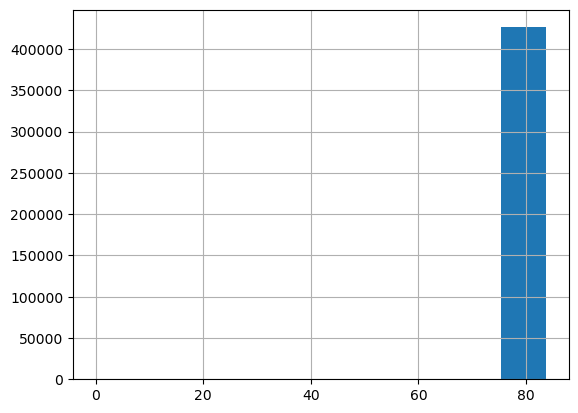

In [407]:
telemetry_df.lon.hist();

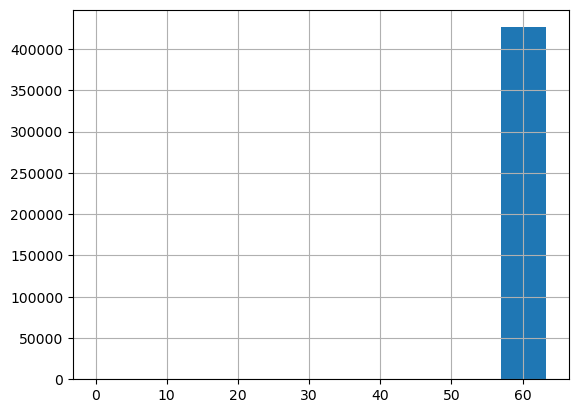

In [408]:
telemetry_df.lat.hist();

In [409]:
telemetry_df.isna().sum()

objectid                     0
time                         0
lat                          0
lon                          0
speed                        0
height                       0
fuel_cons                    0
engine_speed            167119
hdop                         0
DQ_vertical_bump             0
accelerator_position         0
fuel_tank_level         259204
weight_dynamic          259203
tripid                     955
weight                     955
driverid                   955
w_fl                         0
x                            0
y                            0
dtype: int64

In [410]:
print(f'Уникальный идентификатор выбросов по широте и долготе: {telemetry_df[(telemetry_df.lon == 0.0) | (telemetry_df.lat == 0.0)].objectid.unique()[0]}')

Уникальный идентификатор выбросов по широте и долготе: 1121


Заметим, что вывод аналогичен и для координат x,y

In [411]:
telemetry_df[(telemetry_df.x < 50000) | (telemetry_df.lat < 6)][['objectid', 'lat', 'lon', 'x', 'y']]

,objectid,lat,lon,x,y
61753,1121,0.000000,0.000000,0.000000,0.000000
69331,1121,0.000000,0.000000,0.000000,0.000000
123737,1121,0.000000,0.000000,0.000000,0.000000
155198,1121,0.000000,0.000000,0.000000,0.000000
183492,1121,0.000000,0.000000,0.000000,0.000000
214743,1121,0.000000,0.000000,0.000000,0.000000
355665,1121,0.000000,0.000000,0.000000,0.000000
362743,1121,0.000000,0.000000,0.000000,0.000000
386402,1121,0.000000,0.000000,0.000000,0.000000
388174,1121,0.000000,0.000000,0.000000,0.000000


In [412]:
# удаляем показатели с нулями в lat и lon (lat|lon == 0.0)
telemetry_df = telemetry_df[(telemetry_df.lon != 0.0) & (telemetry_df.lat != 0.0)]
telemetry_df.head(10)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.700000,390.000000,NaN,99.990000,0,0,60.000000,216.000000,1003671.000000,215.000000,2891.000000,1,636592.202274,7025133.208573
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.000000,280.000000,0.000000,0.000000,8.000000,0,0,NaN,NaN,1003657.000000,216.000000,2887.000000,0,637716.857273,7025865.991589
2,1124,2023-11-08 19:20:55+07:00,63.343592,83.739678,4.200000,228.000000,66.850000,778.000000,5.000000,0,0,NaN,NaN,1003798.000000,217.000000,2875.000000,0,637106.943106,7026802.535174
3,1124,2023-11-08 14:16:39+07:00,63.343290,83.751773,16.800000,278.000000,2.450000,743.375000,6.000000,0,0,NaN,NaN,1003749.000000,209.000000,2875.000000,0,637713.403209,7026794.840531
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.000000,70.900000,17.000000,NaN,99.990000,0,0,38.000000,0.000000,1003728.000000,204.000000,2894.000000,0,638449.084136,7025558.622181
5,1121,2023-11-08 11:07:48.346000+07:00,63.331924,83.765388,0.009260,70.500000,2.000000,NaN,99.990000,0,0,38.000000,0.000000,1003728.000000,204.000000,2894.000000,0,638449.084136,7025558.622181
6,1126,2023-11-08 04:07:24+07:00,63.336267,83.747848,22.500000,277.000000,170.650000,1428.000000,7.000000,0,0,NaN,NaN,1003662.000000,210.000000,2907.000000,1,637550.606949,7026004.430540
7,1124,2023-11-08 01:36:32+07:00,63.340780,83.748519,22.200000,281.000000,176.450000,1394.250000,8.000000,0,0,NaN,NaN,1003641.000000,212.000000,2884.000000,1,637562.621232,7026508.374488
8,1125,2023-11-08 05:34:15+07:00,63.336234,83.748103,19.800000,260.000000,206.900000,1465.000000,8.000000,0,0,NaN,NaN,1003674.000000,211.000000,2887.000000,1,637563.523399,7026001.303401
9,1123,2023-11-08 09:09:34.730000+07:00,63.342024,83.703988,13.232500,28.900000,2.000000,NaN,0.870000,0,0,68.000000,219.000000,1003705.000000,219.000000,2878.000000,1,635329.007337,7026552.087310


In [413]:
# определим уникальные цвета для каждого идентификатора самосвала
unique_ids = telemetry_df.objectid.unique()
print(unique_ids)
num_ids = len(unique_ids)
colors = plt.cm.viridis(np.linspace(0, 1, num_ids))

# сделаем словарь для соответствия идентификаторов самосвалов и цветов
id_color_mapping = dict(zip(unique_ids, colors))

# теперь создадим массив цветов для каждого объекта в соответствии с его идентификатором
point_colors = [id_color_mapping[id_] for id_ in telemetry_df.objectid]

[1121 1125 1124 1126 1123 1122]


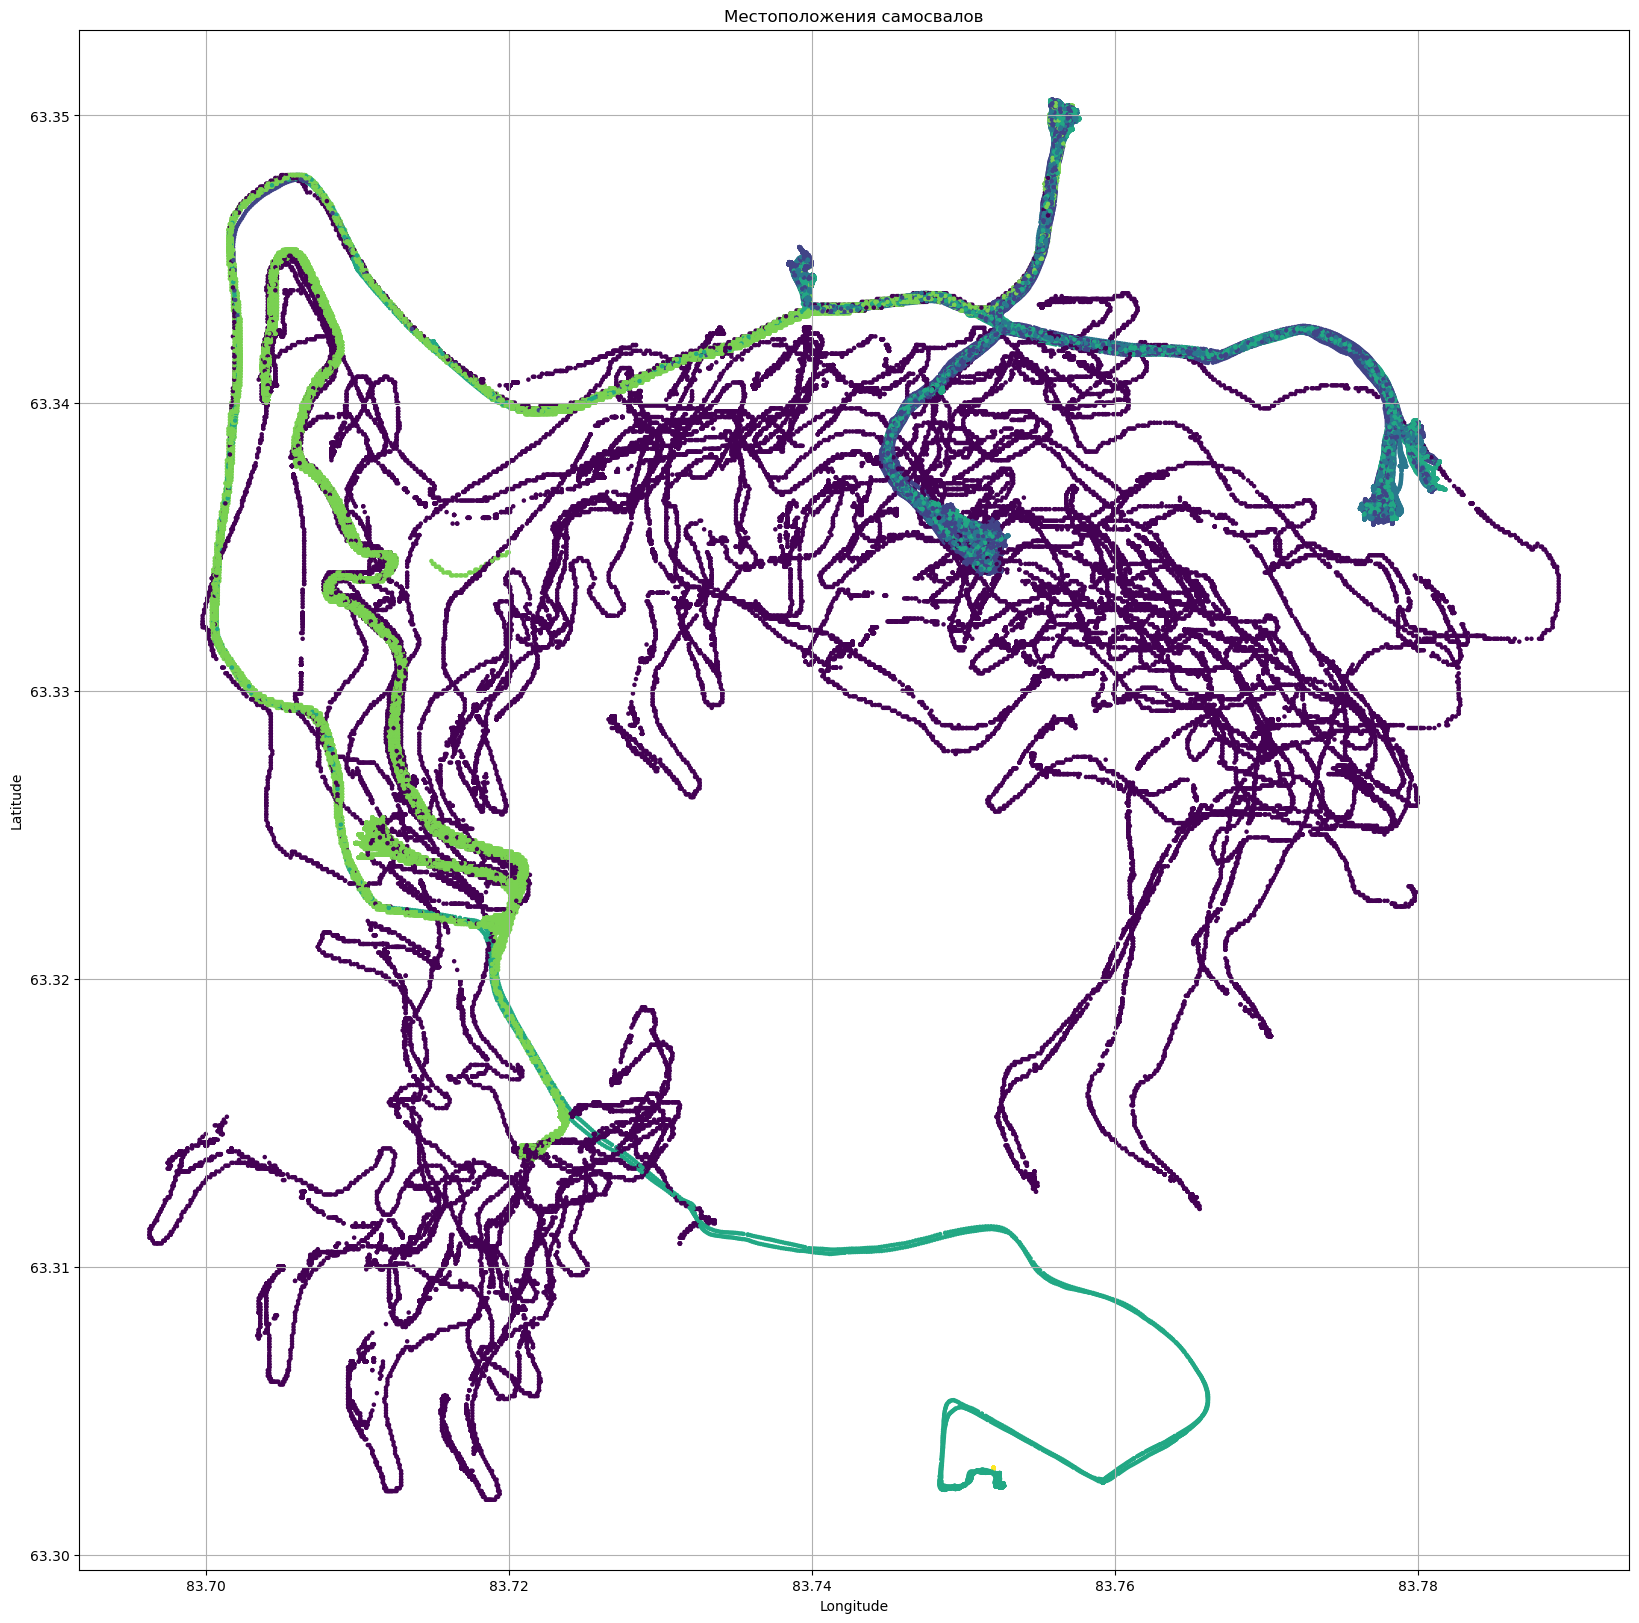

In [414]:
plt.figure(figsize=(20, 20))
plt.scatter(telemetry_df['lon'], telemetry_df['lat'], s = 5, c = point_colors)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Местоположения самосвалов')
plt.grid(True)
plt.show();

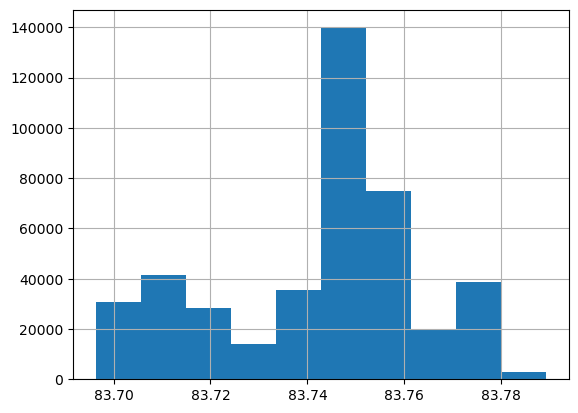

In [415]:
telemetry_df.lon.hist();

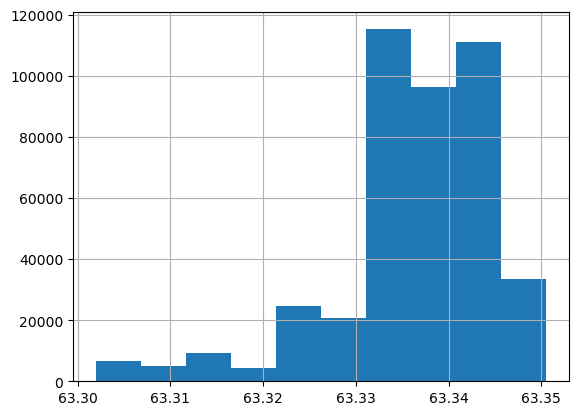

In [416]:
telemetry_df.lat.hist();

Точно есть одна желтая точка справа снизу и зеленый отрезок слева ближе к центру

In [417]:
telemetry_df.objectid.value_counts()

1125    86401
1124    86401
1126    86401
1121    86119
1123    80638
1122      352
Name: objectid, dtype: int64

In [418]:
telemetry_df[telemetry_df.objectid == 1122] # дубликаты всего, кроме времени 

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
1073,1122,2023-11-08 20:59:39.486000+07:00,63.303024,83.751988,0.001852,236.900000,28.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
1226,1122,2023-11-08 21:02:02.486000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
1470,1122,2023-11-08 21:02:33.471000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
1606,1122,2023-11-08 21:03:12.483000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
4443,1122,2023-11-08 20:58:39.492000+07:00,63.303024,83.751988,0.135196,237.000000,35.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421955,1122,2023-11-08 21:03:00.471000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
422266,1122,2023-11-08 20:58:12.496000+07:00,63.303024,83.751988,0.000000,237.000000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
422442,1122,2023-11-08 21:02:22.488000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402
422651,1122,2023-11-08 21:01:56.499000+07:00,63.303024,83.751988,0.001852,236.900000,0.000000,NaN,99.990000,0,0,26.000000,0.000000,NaN,NaN,NaN,0,637916.728420,7022311.866402


In [419]:
# в этом случае этот грузовик нам ничего не даст, для обучение 1 наблюдение плохо поэтому удалим этот выброс
telemetry_df = telemetry_df[telemetry_df.objectid != 1122] 

In [420]:
# выберем данные для объекта с objectid == 1123, для которого у нас огрызок нарисован
obj_1123 = telemetry_df[telemetry_df['objectid'] == 1123].copy()

#выделими исследуемый сегмент
obj_1123 = obj_1123[(obj_1123.lat > 63.33) & (obj_1123.lat < 63.336)]
obj_1123 = obj_1123[(obj_1123.lon > 83.71) & (obj_1123.lon < 83.72)]

# отсортируем данные по убыванию lat и посчитаем разницу между соседними элементами
obj_1123 = obj_1123.sort_values(by = 'lat', ascending = False)
obj_1123['lat_diff'] = obj_1123['lat'].diff()

# отсортируем данные по убыванию lon и посчитаем разницу между соседними элементами
obj_1123 = obj_1123.sort_values(by = 'lon', ascending = False)
obj_1123['lon_diff'] = obj_1123['lon'].diff()

obj_1123.head(10)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y,lat_diff,lon_diff
374661,1123,2023-11-08 19:55:49.276000+07:00,63.334824,83.719988,23.398200,10.500000,1.000000,NaN,1.220000,0,...,47.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636163.453648,7025784.269823,0.000000,NaN
289269,1123,2023-11-08 19:55:50.277000+07:00,63.334824,83.719888,25.740900,10.000000,2.000000,NaN,1.300000,0,...,47.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636158.449863,7025784.057388,0.000000,-0.000100
308153,1123,2023-11-08 19:55:51.278000+07:00,63.334724,83.719788,28.017100,9.300000,117.000000,NaN,1.070000,0,...,48.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636153.918775,7025772.710222,0.000000,-0.000100
273836,1123,2023-11-08 19:55:52.279000+07:00,63.334724,83.719588,30.437600,8.500000,103.000000,NaN,1.100000,0,...,47.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636143.911170,7025772.285389,0.000000,-0.000200
297473,1123,2023-11-08 19:55:53.279000+07:00,63.334724,83.719488,32.860000,7.600000,1.000000,NaN,1.150000,0,...,48.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636138.907367,7025772.072985,0.000000,-0.000100
312885,1123,2023-11-08 19:55:54.283000+07:00,63.334624,83.719288,34.375000,6.700000,7.000000,NaN,1.150000,0,...,48.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636129.372370,7025760.513459,0.000000,-0.000200
118231,1123,2023-11-08 19:55:55.282000+07:00,63.334624,83.719188,34.539800,6.000000,62.000000,NaN,1.200000,0,...,48.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636124.368549,7025760.301077,0.000000,-0.000100
288741,1123,2023-11-08 19:55:56.283000+07:00,63.334624,83.719088,35.112100,5.300000,11.000000,NaN,1.090000,0,...,48.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636119.364727,7025760.088703,0.000000,-0.000100
356793,1123,2023-11-08 19:55:57.283000+07:00,63.334524,83.718888,35.849200,4.600000,2.000000,NaN,1.090000,0,...,47.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636109.829624,7025748.529236,0.000000,-0.000200
195647,1123,2023-11-08 19:55:58.285000+07:00,63.334524,83.718788,35.982500,4.000000,2.000000,NaN,1.070000,0,...,47.000000,0.000000,1003802.000000,202.000000,2878.000000,0,636104.825784,7025748.316885,0.000000,-0.000100


In [421]:
out_inds = obj_1123[(obj_1123['lon_diff'] < 0.0) | (obj_1123['lat_diff'] < 0.0)].index

In [422]:
telemetry_df = telemetry_df[~(telemetry_df.index.isin(out_inds))]

In [423]:
telemetry_df = telemetry_df[~((telemetry_df.lon > 83.718) & (telemetry_df.lat > 63.334) & (telemetry_df.lat < 63.336) & (telemetry_df.objectid == 1123))]

[1121 1125 1124 1126 1123]


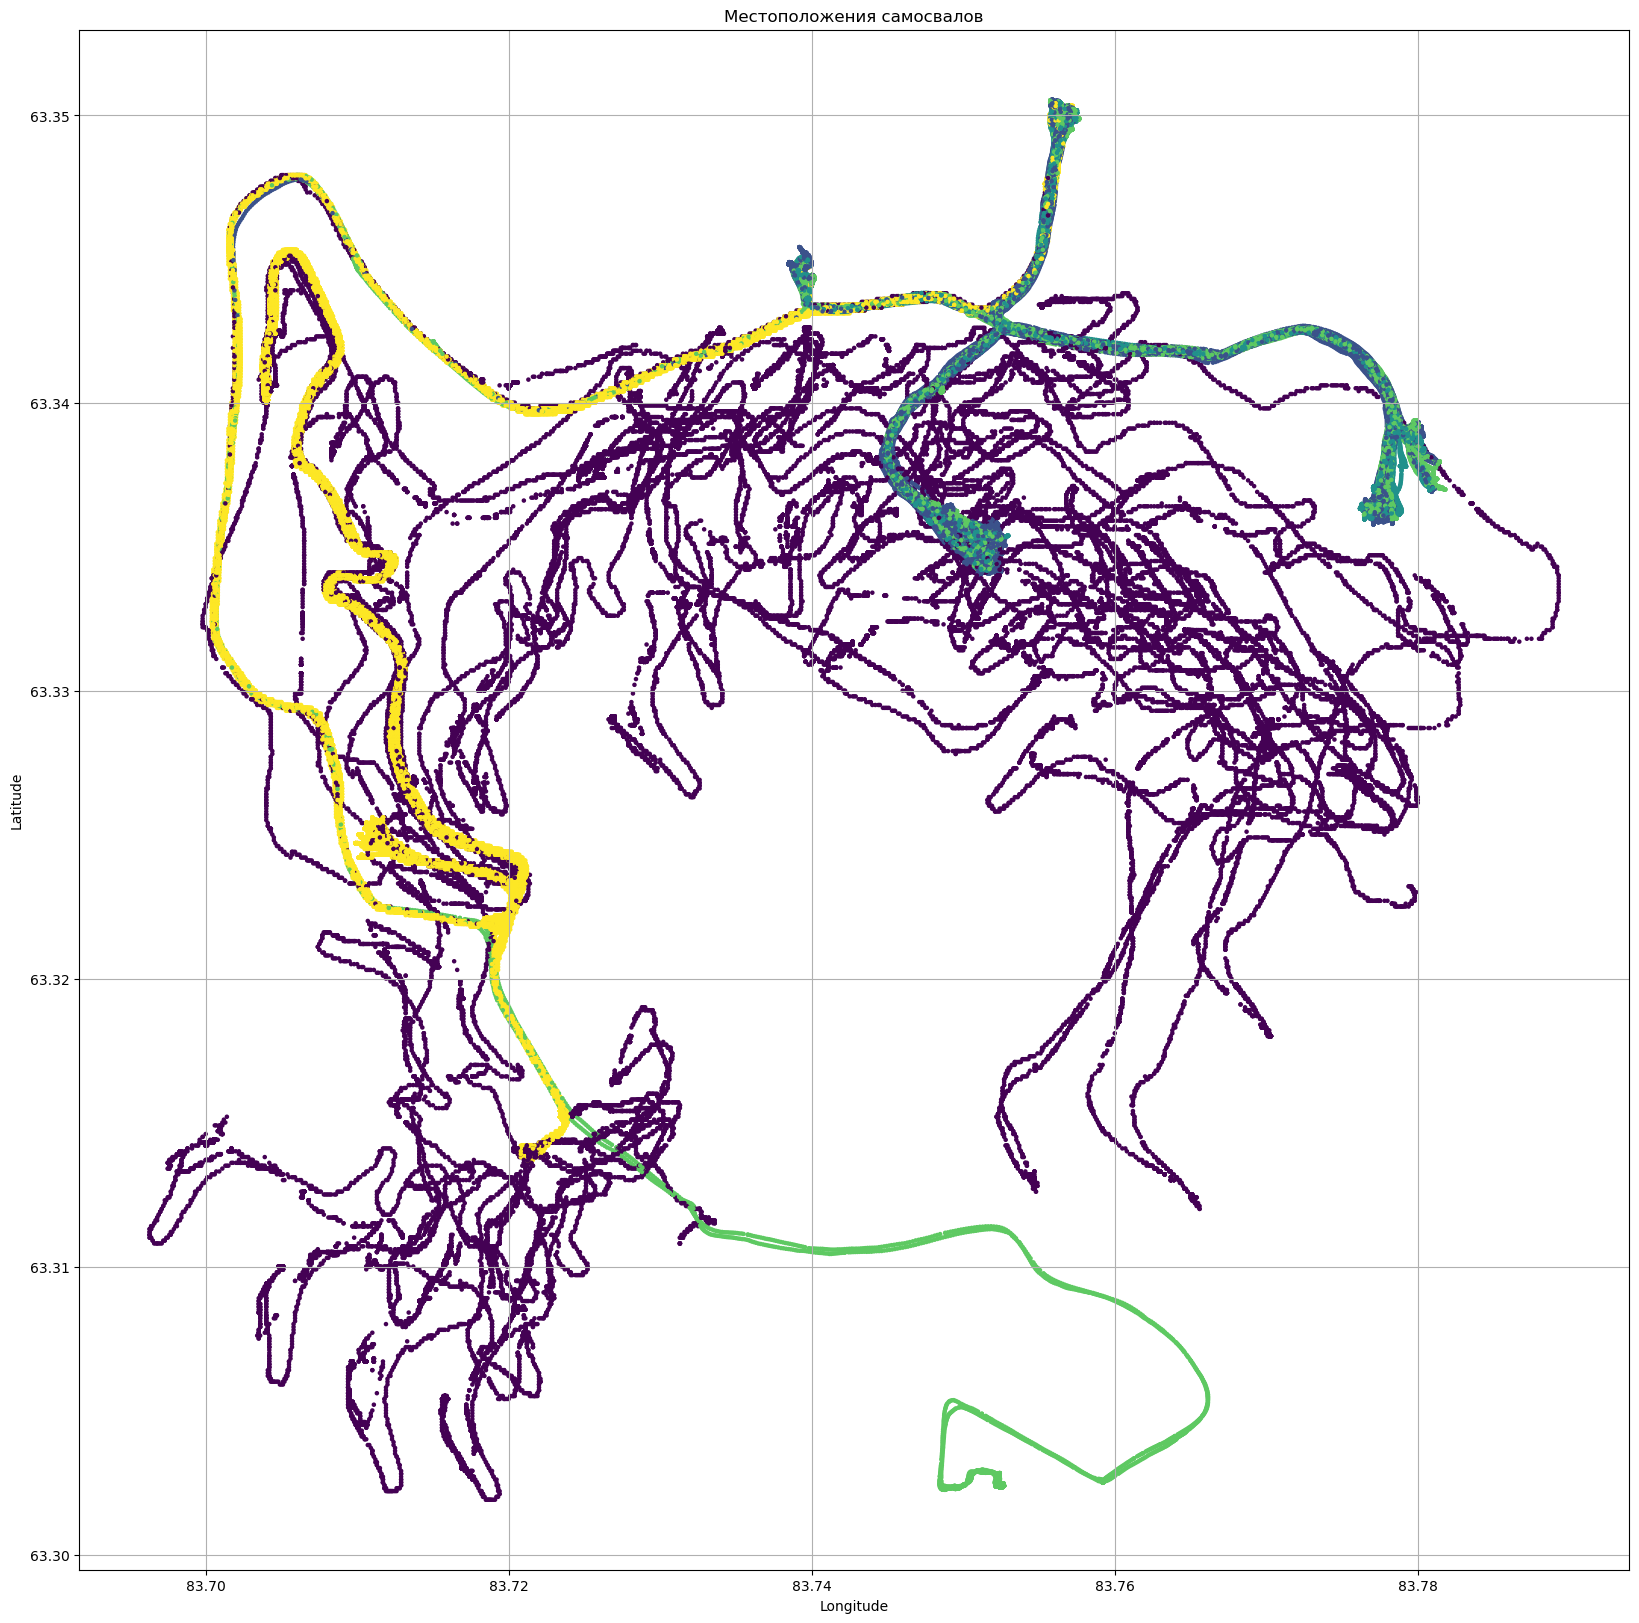

In [424]:
unique_ids2 = telemetry_df.objectid.unique()
print(unique_ids2)
num_ids2 = len(unique_ids2)
colors2 = plt.cm.viridis(np.linspace(0, 1, num_ids2))


id_color_mapping2 = dict(zip(unique_ids2, colors2))

point_colors2 = [id_color_mapping2[id_] for id_ in telemetry_df.objectid]

plt.figure(figsize=(20, 20))
plt.scatter(telemetry_df['lon'], telemetry_df['lat'], s = 5, c = point_colors2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Местоположения самосвалов')
plt.grid(True)
plt.show();

In [425]:
telemetry_df = telemetry_df.fillna(0)

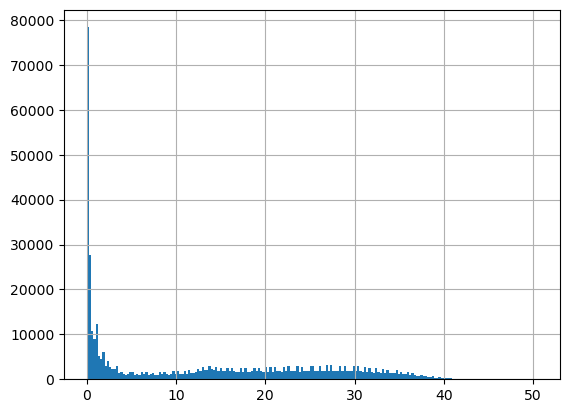

In [426]:
telemetry_df.speed.hist(bins = 200);

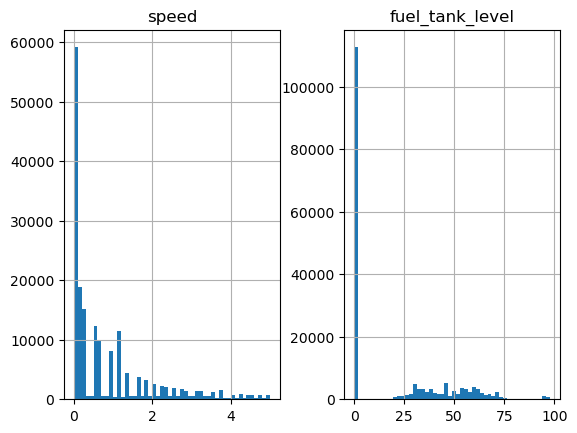

In [427]:
telemetry_df[telemetry_df.speed <= 5][['speed','fuel_tank_level']].hist(bins = 50);

In [428]:
# как может ехать грузовик без бензина? :)
telemetry_df = telemetry_df[~((telemetry_df.speed != 0.0) & (telemetry_df.fuel_tank_level == 0.0))]

In [429]:
# как мы узнаем id водителя, если он неизвестен изначально
telemetry_df = telemetry_df[telemetry_df.driverid != 0]

In [430]:
# высота грузовика не может быть нулевой
telemetry_df = telemetry_df[telemetry_df.height != 0]

## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

In [431]:
# среднее значение по самосвалам
averages_by_trucks = telemetry_df.groupby('objectid')[['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height']].mean()
averages_by_trucks

,hdop,speed,engine_speed,DQ_vertical_bump,height
objectid,,,,,
1121,92.924155,9.919385,0.000000,0.000000,62.157310
1123,2.466129,16.324715,0.000000,0.000000,90.846643
1124,7.238648,0.000000,1037.584114,0.000000,260.873503
1125,8.282402,0.000000,953.379348,0.000000,256.299793
1126,7.732711,0.000000,1059.794281,0.000000,258.926174


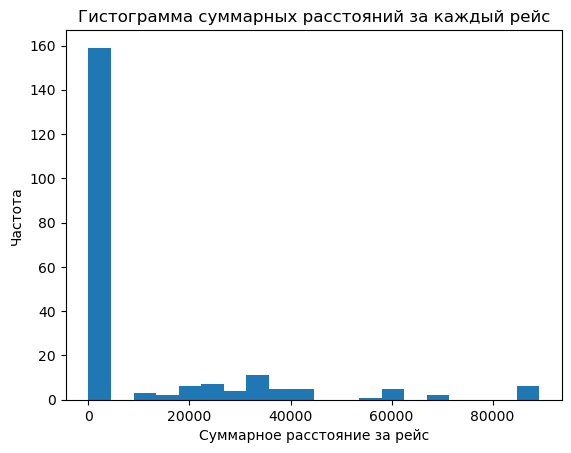

In [432]:
# гистограмма суммарных расстояний за каждый рейс

# группируем данные по рейсам и вычисляем суммарное время для каждого рейса
total_time_seconds = (telemetry_df.groupby('tripid')['time'].max() - telemetry_df.groupby('tripid')['time'].min()).dt.total_seconds()

average_speed = telemetry_df.groupby('tripid')['speed'].mean()

# умножаем среднюю скорость на время, чтобы получить суммарное расстояние
total_distance = average_speed * total_time_seconds

# теперь строим гистограмму суммарных расстояний
plt.hist(total_distance, bins = 20)
plt.xlabel('Суммарное расстояние за рейс')
plt.ylabel('Частота')
plt.title('Гистограмма суммарных расстояний за каждый рейс')
plt.show();

In [433]:
# средние скорости амосвалов за каждый час суток

# извлекаем час из времени 
telemetry_df['hour'] = telemetry_df['time'].dt.hour

# группируем данные по самосвалам и часам, считаем среднюю скорость
average_speeds_by_hour = telemetry_df.groupby(['objectid', 'hour'])['speed'].mean().unstack()

average_speeds_by_hour


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,18.444303,12.862556,8.235196,6.410654,13.865112,5.952499,7.554358,4.958597,7.181664,11.518727,...,6.155436,14.149674,9.615145,8.214560,13.730456,9.263768,9.241412,11.137591,8.723652,5.201494
1123,22.353122,18.699208,21.400921,11.871268,21.843596,15.320866,9.870112,11.861175,16.222656,15.551438,...,21.087706,17.445527,21.079455,11.884093,17.837124,7.844212,12.949142,15.397868,13.564759,4.824030
1124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1126,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [434]:
# выберу по одному рейсу для каждого самосвала
one_trips = telemetry_df[['objectid', 'tripid']].groupby(['objectid'])['tripid'].first()
selected_trips = telemetry_df[telemetry_df['tripid'].isin(one_trips)]
selected_trips

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y,hour
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.700000,390.000000,0.000000,99.990000,0,0,60.000000,216.000000,1003671.000000,215.000000,2891.000000,1,636592.202274,7025133.208573,5
1,1125,2023-11-08 03:21:39+07:00,63.334962,83.751046,0.000000,280.000000,0.000000,0.000000,8.000000,0,0,0.000000,0.000000,1003657.000000,216.000000,2887.000000,0,637716.857273,7025865.991589,3
9,1123,2023-11-08 09:09:34.730000+07:00,63.342024,83.703988,13.232500,28.900000,2.000000,0.000000,0.870000,0,0,68.000000,219.000000,1003705.000000,219.000000,2878.000000,1,635329.007337,7026552.087310,9
13,1124,2023-11-08 13:31:57+07:00,63.350394,83.755886,0.000000,262.000000,38.700000,966.000000,6.000000,0,0,0.000000,0.000000,1003741.000000,213.000000,2875.000000,1,637885.115014,7027594.683544,13
30,1121,2023-11-08 04:49:08.317000+07:00,63.328224,83.716488,3.033580,219.200000,81.000000,0.000000,99.990000,0,0,63.000000,0.000000,1003671.000000,215.000000,2891.000000,0,636019.480326,7025041.945567,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425782,1123,2023-11-08 08:55:37.788000+07:00,63.323424,83.719988,25.659500,131.100000,124.000000,0.000000,1.640000,0,0,68.000000,0.000000,1003705.000000,219.000000,2878.000000,0,636217.342455,7024514.910557,8
425929,1121,2023-11-08 05:17:30.368000+07:00,63.338524,83.730988,0.001852,154.300000,45.000000,0.000000,99.990000,0,0,64.000000,177.000000,1003671.000000,215.000000,2891.000000,1,636696.306315,7026219.668492,5
426014,1123,2023-11-08 09:03:24.751000+07:00,63.341324,83.703888,7.182060,28.700000,124.000000,0.000000,1.250000,0,0,67.000000,0.000000,1003705.000000,219.000000,2878.000000,0,635327.294503,7026473.932324,9
426107,1121,2023-11-08 05:22:16.356000+07:00,63.337624,83.731688,12.195400,136.100000,18.000000,0.000000,99.990000,0,0,65.000000,212.000000,1003671.000000,215.000000,2891.000000,1,636735.601130,7026120.949539,5


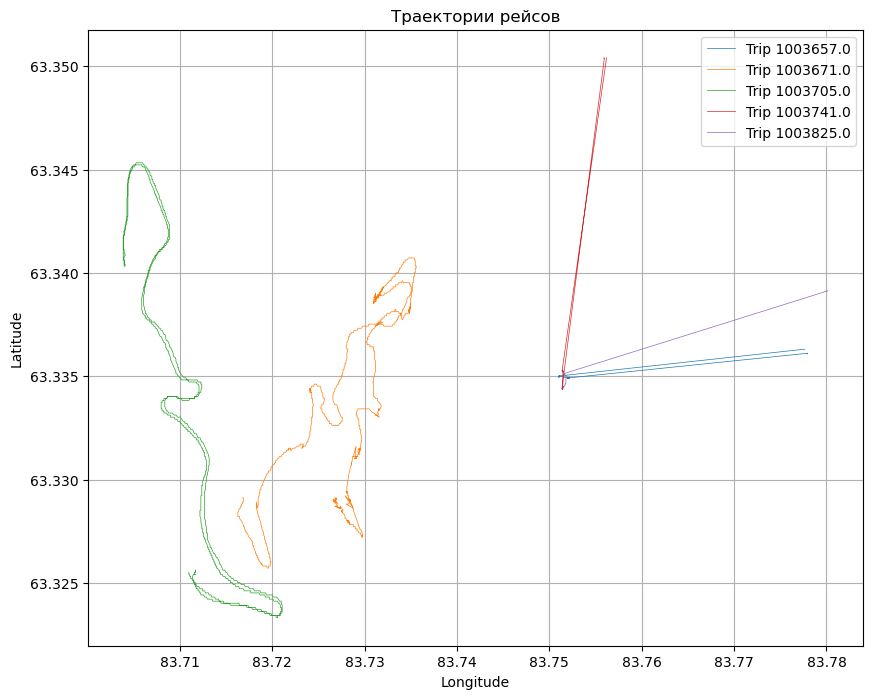

In [435]:
# нарисуем траектории рейсов
plt.figure(figsize=(10, 8))

# теперь нарисуем траектории для каждого рейса из таблицы selected_trips
for tripid, group in selected_trips.groupby('tripid'):
    group_sorted = group.sort_values(by='time')  # сортируем здесь точки по времени
    plt.plot(group_sorted['lon'], group_sorted['lat'], label=f'Trip {tripid}', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Траектории рейсов')
plt.legend()
plt.grid(True)
plt.show();

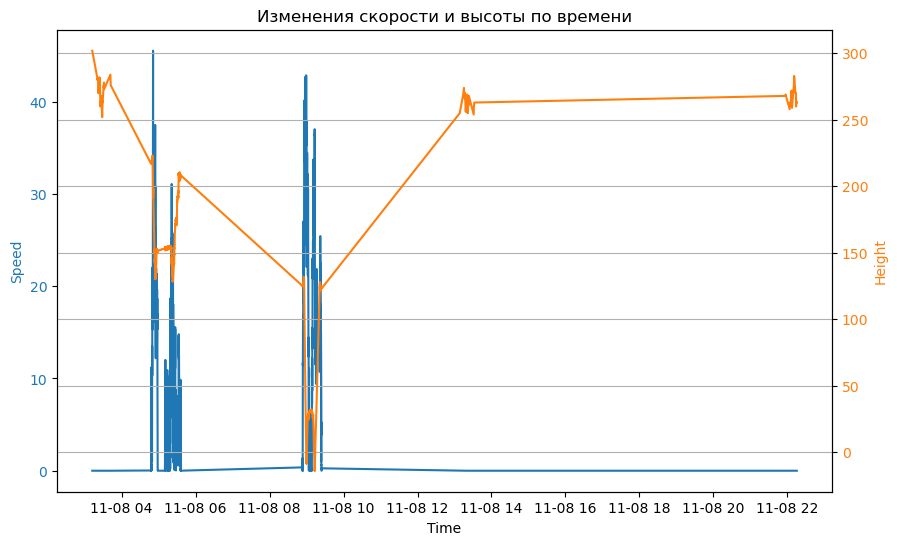

In [436]:
# сортируем данные по времени
selected_trips_sorted = selected_trips.sort_values(by = 'time')

fig, ax1 = plt.subplots(figsize=(10, 6))

# построение кривой скорости по оси времени
ax1.set_xlabel('Time')
ax1.set_ylabel('Speed', color = 'tab:blue')
ax1.plot(selected_trips_sorted['time'], selected_trips_sorted['speed'], color = 'tab:blue')
ax1.tick_params(axis = 'y', labelcolor = 'tab:blue')

# создам вторую ось Y для кривой высоты
ax2 = ax1.twinx()  
ax2.set_ylabel('Height', color = 'tab:orange')
ax2.plot(selected_trips_sorted['time'], selected_trips_sorted['height'], color = 'tab:orange')
ax2.tick_params(axis = 'y', labelcolor = 'tab:orange')


plt.title('Изменения скорости и высоты по времени')
plt.grid(True)

plt.show();

In [437]:
telemetry_df['time_id'] = telemetry_df['time'].dt.strftime('%Y-%m-%d %H')

In [438]:
# выгрузим второй датасет
weather = pd.read_parquet('weather_hourly.parquet')
weather['time_id'] = weather['time'].dt.strftime('%Y-%m-%d %H')
weather

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info,time_id
0,2023-11-07 20:00:00+00:00,0.000000,0.000000,-13.270000,-20.020000,-17.590000,67.000000,1027.000000,3.480000,8.910000,60.000000,100.000000,10000.000000,clouds,0,0,1,2023-11-07 20
1,2023-11-08 06:00:00+00:00,0.000000,0.000000,-9.270000,-15.790000,-16.070000,54.000000,1020.000000,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1,2023-11-08 06
2,2023-11-07 18:00:00+00:00,0.000000,0.000000,-13.270000,-20.100000,-17.590000,67.000000,1028.000000,3.550000,8.920000,62.000000,95.000000,10000.000000,clouds,0,0,1,2023-11-07 18
3,2023-11-07 16:00:00+00:00,0.000000,0.000000,-13.270000,-19.670000,-17.440000,68.000000,1030.000000,3.180000,7.710000,61.000000,94.000000,10000.000000,clouds,0,0,1,2023-11-07 16
4,2023-11-07 11:00:00+00:00,0.000000,0.000000,-10.270000,-16.630000,-14.370000,69.000000,1033.000000,3.720000,9.600000,64.000000,65.000000,10000.000000,clouds,0,0,1,2023-11-07 11
5,2023-11-07 14:00:00+00:00,0.000000,0.000000,-12.270000,-18.560000,-16.630000,67.000000,1032.000000,3.260000,9.110000,66.000000,88.000000,10000.000000,clouds,0,0,1,2023-11-07 14
6,2023-11-07 23:00:00+00:00,0.000000,0.000000,-12.270000,-18.870000,-17.280000,63.000000,1025.000000,3.530000,9.310000,62.000000,100.000000,10000.000000,clouds,0,0,1,2023-11-07 23
7,2023-11-09 14:00:00+00:00,0.000000,0.200000,0.730000,-2.750000,-0.240000,93.000000,1016.000000,3.150000,9.240000,193.000000,100.000000,10000.000000,clouds,0,0,1,2023-11-09 14
8,2023-11-09 10:00:00+00:00,0.440000,0.760000,0.730000,-2.300000,0.450000,98.000000,1016.000000,2.650000,9.310000,197.000000,100.000000,498.000000,snow,0,1,1,2023-11-09 10
9,2023-11-08 23:00:00+00:00,0.130000,0.560000,-4.270000,-8.890000,-4.870000,95.000000,1016.000000,3.260000,8.910000,161.000000,100.000000,1273.000000,snow,0,1,1,2023-11-08 23


In [441]:
# соединим датасеты
df_total = pd.merge(telemetry_df, weather.drop(['time'], axis = 1), on = 'time_id', how = 'inner')
df_total

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.700000,390.000000,0.000000,99.990000,0,...,1021.000000,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1
1,1123,2023-11-08 05:06:01.779000+07:00,63.343324,83.744388,15.890200,245.300000,399.000000,0.000000,1.250000,0,...,1021.000000,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1
2,1121,2023-11-08 05:45:47.383000+07:00,63.342224,83.739688,14.375200,139.500000,28.000000,0.000000,99.990000,0,...,1021.000000,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1
3,1121,2023-11-08 05:07:27.371000+07:00,63.338924,83.731588,0.000000,152.900000,27.000000,0.000000,99.990000,0,...,1021.000000,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1
4,1121,2023-11-08 05:15:50.368000+07:00,63.338524,83.730988,0.396328,154.700000,27.000000,0.000000,99.990000,0,...,1021.000000,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180876,1123,2023-11-08 06:51:24.780000+07:00,63.315224,83.723388,0.001852,176.500000,14.000000,0.000000,1.620000,0,...,1020.000000,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1
180877,1121,2023-11-08 06:59:39.363000+07:00,63.338524,83.746288,13.352900,96.600000,2.000000,0.000000,99.990000,0,...,1020.000000,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1
180878,1123,2023-11-08 06:29:23.752000+07:00,63.315524,83.723388,0.003704,174.400000,12.000000,0.000000,2.550000,0,...,1020.000000,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1
180879,1123,2023-11-08 06:01:43.755000+07:00,63.341024,83.703988,3.392860,46.000000,147.000000,0.000000,1.580000,0,...,1020.000000,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1


In [449]:
df_total = df_total.drop(['time_id'], axis = 1)

## Задание 3

**Обучить модель для предсказания значений скорости самосвала (колонка speed)**
* Можно (и даже нужно) генерировать дополнительные фичи.
* Выполнить необходимые (на Ваш взгляд) преобразования датасета.
* Выбрать метрику(и) для оценки качества модели, объяснить причину выбора данной метрики
* Обучить несколько моделей и сравнить их. Интерпретировать результаты.

In [456]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [450]:
label_encoder = LabelEncoder()
df_total['precipType_encoded'] = label_encoder.fit_transform(df_total['precipType'])

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info,precipType_encoded
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.700000,390.000000,0.000000,99.990000,0,...,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1,0
1,1123,2023-11-08 05:06:01.779000+07:00,63.343324,83.744388,15.890200,245.300000,399.000000,0.000000,1.250000,0,...,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1,0
2,1121,2023-11-08 05:45:47.383000+07:00,63.342224,83.739688,14.375200,139.500000,28.000000,0.000000,99.990000,0,...,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1,0
3,1121,2023-11-08 05:07:27.371000+07:00,63.338924,83.731588,0.000000,152.900000,27.000000,0.000000,99.990000,0,...,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1,0
4,1121,2023-11-08 05:15:50.368000+07:00,63.338524,83.730988,0.396328,154.700000,27.000000,0.000000,99.990000,0,...,4.200000,9.010000,73.000000,100.000000,10000.000000,clouds,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180876,1123,2023-11-08 06:51:24.780000+07:00,63.315224,83.723388,0.001852,176.500000,14.000000,0.000000,1.620000,0,...,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1,0
180877,1121,2023-11-08 06:59:39.363000+07:00,63.338524,83.746288,13.352900,96.600000,2.000000,0.000000,99.990000,0,...,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1,0
180878,1123,2023-11-08 06:29:23.752000+07:00,63.315524,83.723388,0.003704,174.400000,12.000000,0.000000,2.550000,0,...,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1,0
180879,1123,2023-11-08 06:01:43.755000+07:00,63.341024,83.703988,3.392860,46.000000,147.000000,0.000000,1.580000,0,...,4.130000,8.200000,71.000000,100.000000,10000.000000,clouds,0,0,1,0


In [453]:
df_total['year'] = df_total['time'].dt.year
df_total['month'] = df_total['time'].dt.month
df_total['day'] = df_total['time'].dt.day
df_total['hour'] = df_total['time'].dt.hour
df_total['minute'] = df_total['time'].dt.minute
df_total['second'] = df_total['time'].dt.second

In [454]:
df_total = df_total.drop(['time', 'precipType'], axis = 1)

In [455]:
df_total

,objectid,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,...,visibility,rain,snow,no_weather_info,precipType_encoded,year,month,day,minute,second
0,1121,63.328824,83.727988,3.003940,195.700000,390.000000,0.000000,99.990000,0,0,...,10000.000000,0,0,1,0,2023,11,8,31,31
1,1123,63.343324,83.744388,15.890200,245.300000,399.000000,0.000000,1.250000,0,0,...,10000.000000,0,0,1,0,2023,11,8,6,1
2,1121,63.342224,83.739688,14.375200,139.500000,28.000000,0.000000,99.990000,0,0,...,10000.000000,0,0,1,0,2023,11,8,45,47
3,1121,63.338924,83.731588,0.000000,152.900000,27.000000,0.000000,99.990000,0,0,...,10000.000000,0,0,1,0,2023,11,8,7,27
4,1121,63.338524,83.730988,0.396328,154.700000,27.000000,0.000000,99.990000,0,0,...,10000.000000,0,0,1,0,2023,11,8,15,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180876,1123,63.315224,83.723388,0.001852,176.500000,14.000000,0.000000,1.620000,0,0,...,10000.000000,0,0,1,0,2023,11,8,51,24
180877,1121,63.338524,83.746288,13.352900,96.600000,2.000000,0.000000,99.990000,0,0,...,10000.000000,0,0,1,0,2023,11,8,59,39
180878,1123,63.315524,83.723388,0.003704,174.400000,12.000000,0.000000,2.550000,0,0,...,10000.000000,0,0,1,0,2023,11,8,29,23
180879,1123,63.341024,83.703988,3.392860,46.000000,147.000000,0.000000,1.580000,0,0,...,10000.000000,0,0,1,0,2023,11,8,1,43


Так как у нас задача регрессии (предсказание скорости), значит метрики нужно брать MSE, MAE, RMSE

In [461]:
X = df_total.drop(columns = ['speed'])  # признаки
y = df_total['speed']  # целевая переменная

# делим данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# определяем категориальные и числовые признаки
numeric_features = ['objectid', 'lat', 'lon', 'height', 'fuel_cons',
                   'engine_speed', 'hdop', 'DQ_vertical_bump', 'accelerator_position',
                   'fuel_tank_level', 'weight_dynamic', 'tripid', 'weight', 'driverid',
                   'w_fl', 'x', 'y', 'hour', 'precipIntensity', 'precipProbability',
                   'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
                   'pressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
                   'visibility', 'year', 'month', 'day', 'minute', 'second']

categorical_features = ['precipType_encoded', 'rain', 'snow', 'no_weather_info']

# создаем предобработчик для числовых и категориальных признаков
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')
 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# выберем модели
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state = 42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state = 42))
]

# обучим и оценим каждую модель
for name, model in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    # здесь будем оценивать производительность модели
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)
    
    # метрики для каждой модели
    print(f'Model: {name}')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R^2: {r2:.4f}')

Model: Linear Regression
MAE: 9.0564
MSE: 115.6349
RMSE: 10.7534
R^2: 0.2396
Model: Random Forest
MAE: 0.6148
MSE: 1.6457
RMSE: 1.2829
R^2: 0.9892
Model: Gradient Boosting
MAE: 5.1805
MSE: 46.2526
RMSE: 6.8009
R^2: 0.6959


Исходя из оценок метрик, модель линейной регрессии показывает не очень хороший уровень точности. R^2 показывает, что модель объясняет около 24% дисперсии целевой переменной. Чего не скажешь про модель случайного леса, которая показывает высокую точность прогнозирования, где R^2 близок к 1, что означает, что модель хорошо объясняет изменения в целевой переменной. Модель градиентного бустинга также показывает хорошую точность, но несколько ниже, чем у модели случайного леса. Однако R^2 все еще высокий и указывает на то, что модель хорошо объясняет изменения целевой переменной.

На основе этих метрик модель случайного леса показывает лучшую производительность по сравнению с линейной регрессией и градиентным бустингом для данной задачи прогнозирования скорости самосвалов.